Before starting your evaluation, I recommend running all cells as there is a pairplot that takes around 3 minutes. So you can avoid waiting

# Libraries installed

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/a8/07/72953cf70e3bd3a24cbc3e743e6f8539abe6e3e6d83c3c0c83426eaffd39/plotly-5.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 4.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# Libraries used

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tkinter import N
from scipy import stats
from typing import Literal
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.colors as mcolors
from IPython.display import Markdown
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Download and load dataset

The following functions are used to allow users to add their own filepath or URL. Nevertheless, if you don't want to use them, in the next code cell you can find a preloaded file, ready to use.

In [3]:
def download_file(url, filename):
    """
    Download a file from the given URL and save it with the specified filename.

    Parameters:
    - url (str): The URL from which to download the file.
    - filename (str): The name to use when saving the downloaded file.

    Returns:
    None

    Raises:
    - FileNotFoundError: If the file specified by 'filename' is not found after attempting to download.
    - Exception: If an unexpected error occurs during the download process.
    """
    if not(os.path.isfile(filename)):
        print("Downloading file...")

        wget.download(url, filename)
        print(f"Current path: {os.getcwd()}")
        print("Files:")
        print(os.listdir())


def read_file() -> pd.DataFrame:
    """
    Prompt the user for a file path or URL, download the file if it's a URL, and read it into a Pandas DataFrame.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the specified file.

    Raises:
    - pd.errors.ParserError: If there is an issue parsing the file (e.g., incorrect file format).
    - FileNotFoundError: If the specified file is not found.
    - Exception: If an unexpected error occurs during the file reading process.
    """
    while True:
        try:
            file_or_url = input("Enter the file path or URL: ")

            if file_or_url.startswith("http"):
                filename = file_or_url.split("/")[-1] + ".csv"
                download_file(file_or_url, filename)
                return pd.read_csv(filename)

            filename_lowercase = file_or_url.lower()

            if filename_lowercase.endswith('.csv'):
                return pd.read_csv(filename_lowercase)

            if filename_lowercase.endswith(('.xls', '.xlsx')):
                return pd.read_excel(filename_lowercase)

            if filename_lowercase.endswith('.json'):
                return pd.read_json(filename_lowercase)

            print("Unsupported file format. Please provide a CSV, Excel, or JSON file.")

        except pd.errors.ParserError:
            print("Error: Unable to parse the file. Please check the file format.")
        except FileNotFoundError:
            print("Error: File not found. Please enter a valid file path or URL.")
        except Exception as e:
            print(f"An error occurred: {e}")


#df = read_file()
#print(df)


Here is the preloaded file

In [3]:
df = pd.read_csv('../datasets/cleaned_data.csv')

print("\nHead:\n")
print(df.head())


Head:

             timestamp  age     sex relationship_status          occupation  \
0  2022-04-18 19:18:47   21    Male   In a relationship  University Student   
1  2022-04-18 19:19:28   21  Female              Single  University Student   
2  2022-04-18 19:25:59   21  Female              Single  University Student   
3  2022-04-18 19:29:43   21  Female              Single  University Student   
4  2022-04-18 19:33:31   21  Female              Single  University Student   

  affiliated_organization  social_media_user  \
0              University                  1   
1              University                  1   
2              University                  1   
3              University                  1   
4              University                  1   

                               common_platforms_used  avg_hours_spent_daily  \
0  ['Facebook', 'Twitter', 'Instagram', 'YouTube'...                      3   
1  ['Facebook', 'Twitter', 'Instagram', 'YouTube'...                  

# Analysis

## Correlation

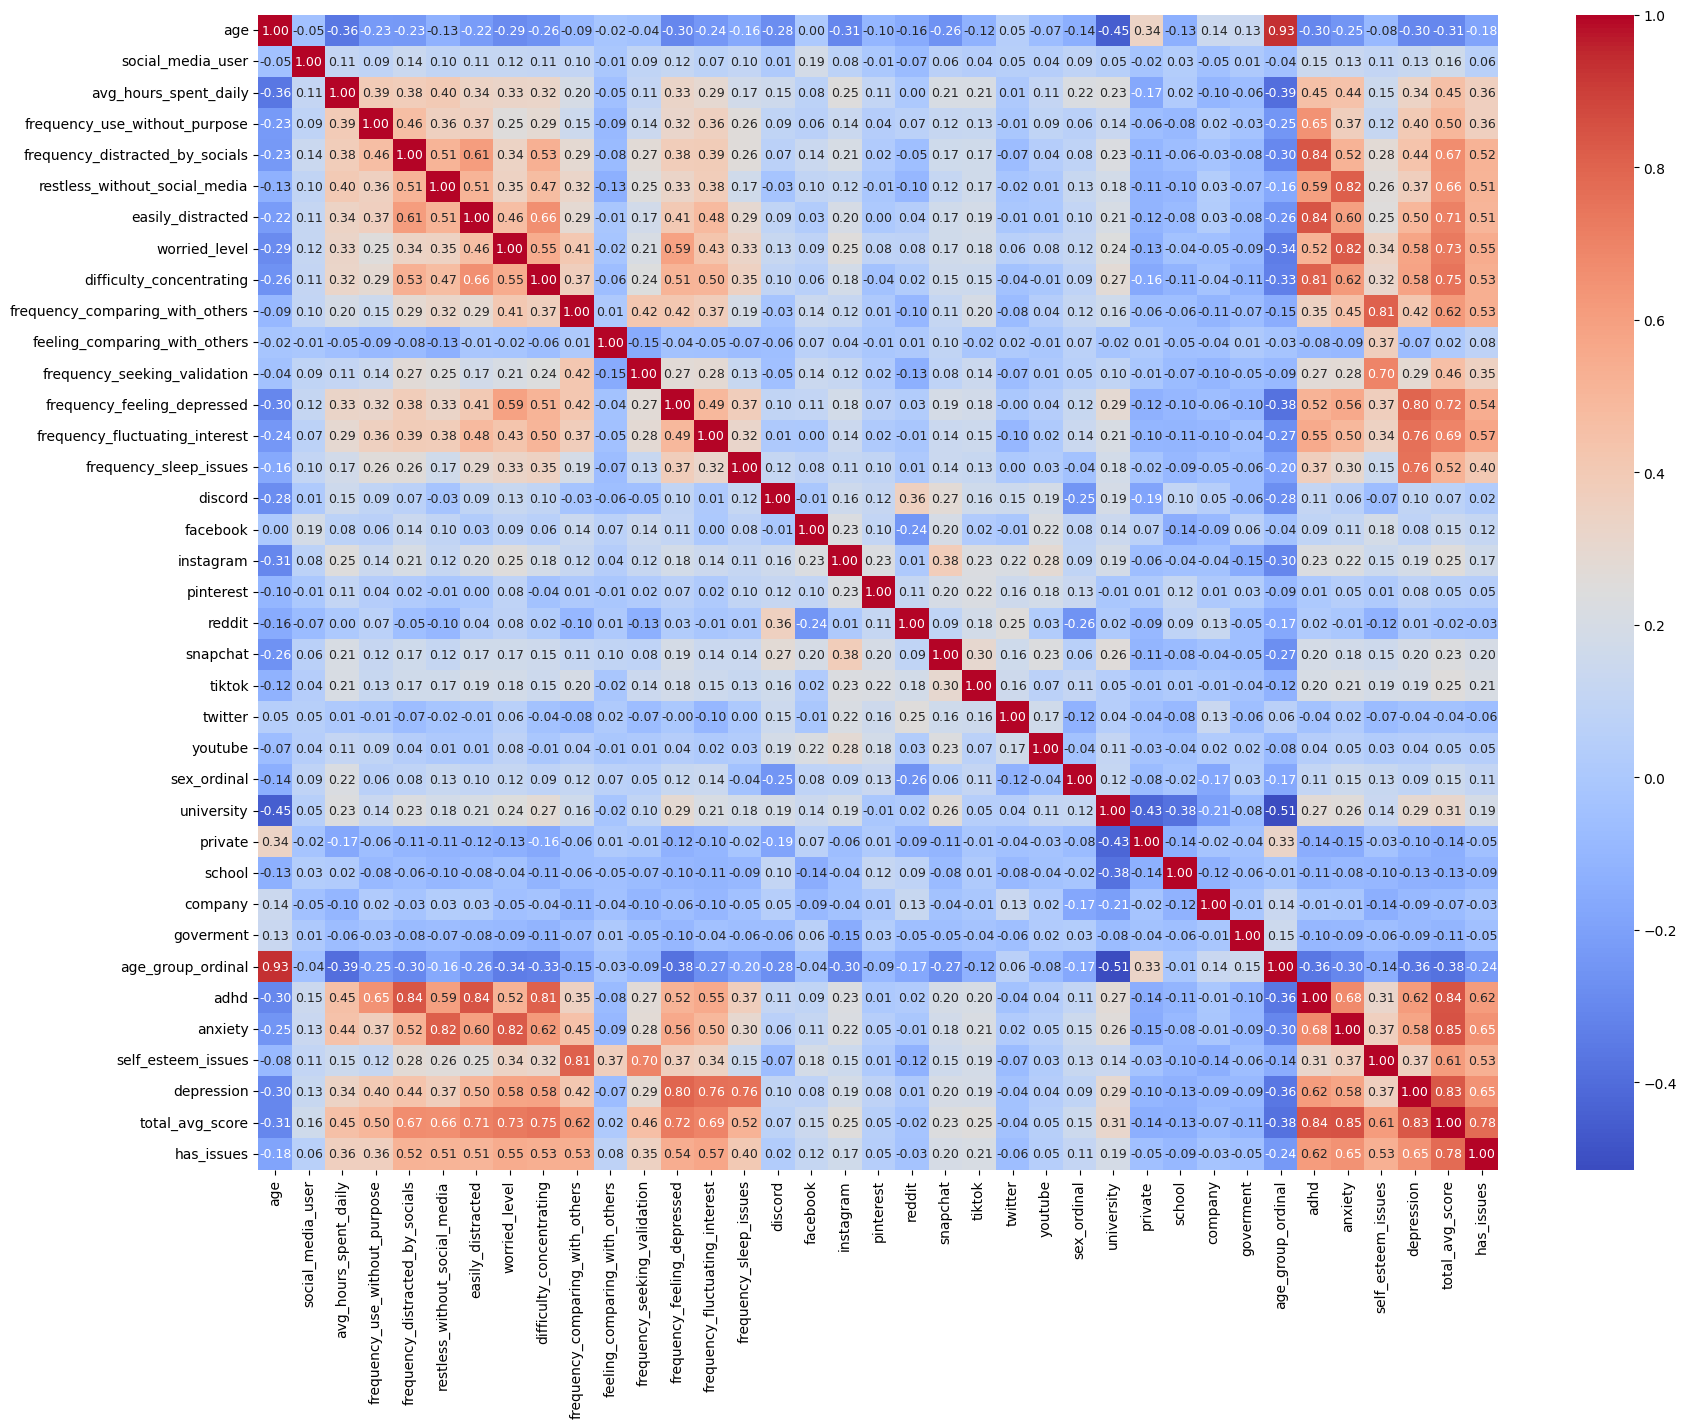

In [4]:
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size':9})
plt.show()

### Filtering Out Statistically Insignificant Correlations

This helps to focus on the variables that have a significant correlation with each other.

By removing all values that don't have a statistical significance (in this case, values between -0.2 and 0.2), we are filtering out the variables that have a weak correlation with each other. This makes it easier to identify the variables that have a stronger correlation, it also helps to simplify the correlation matrix and make it easier to interpret.

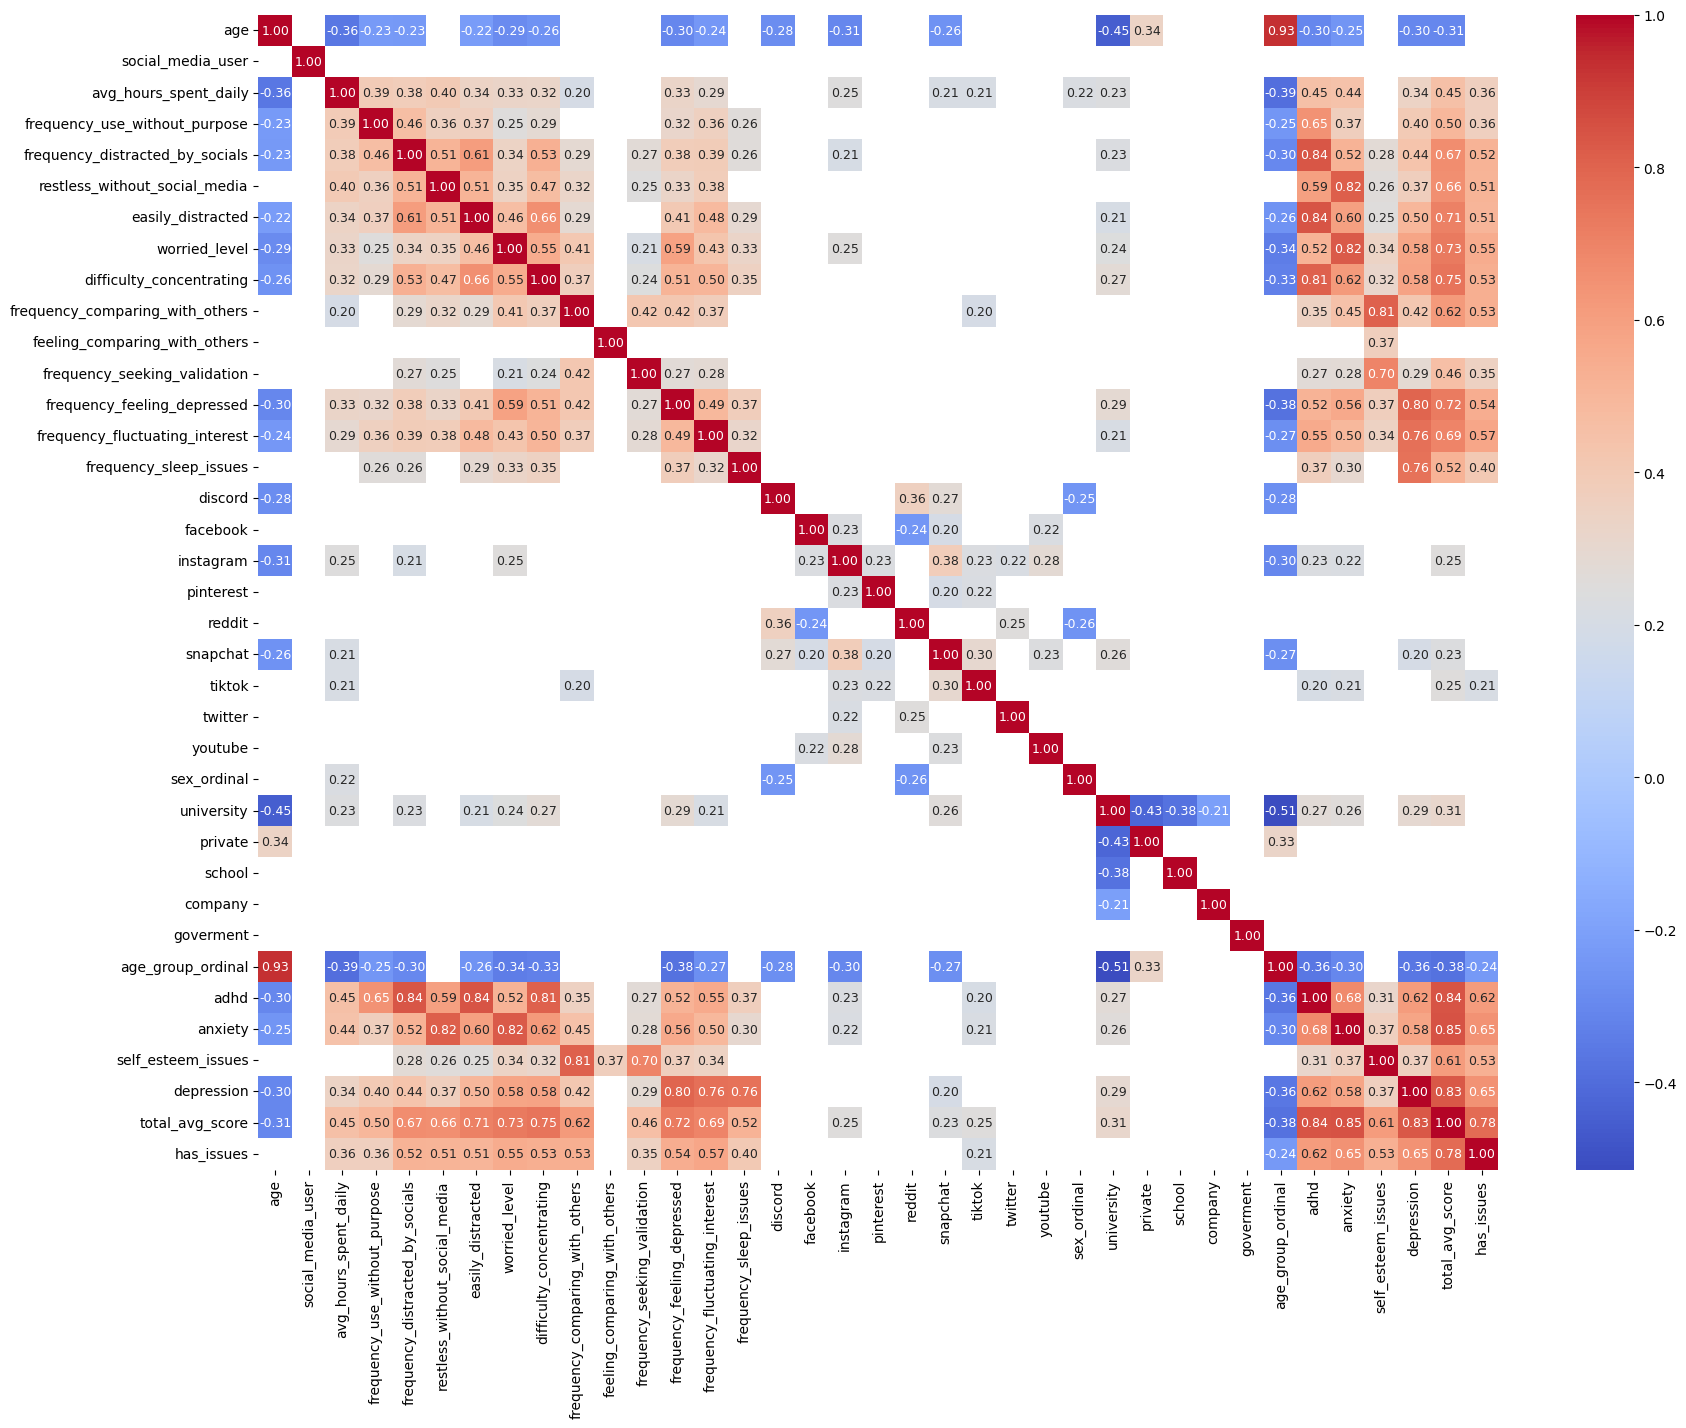

In [6]:
__MIN_SIGNIFICANCE_THRESHOLD__ = 0.2

filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[(filtered_correlation_matrix >= -__MIN_SIGNIFICANCE_THRESHOLD__) 
                            & (filtered_correlation_matrix <= __MIN_SIGNIFICANCE_THRESHOLD__)] = np.nan

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size':9})
plt.show()

Create a text with all filtered correlations

In [7]:
correlations = []

for column in filtered_correlation_matrix.columns:
    for index in filtered_correlation_matrix.index:
        correlation = filtered_correlation_matrix.loc[index, column]
        if pd.notna(correlation) and correlation != 1:
            if correlation < 0:
                correlation_type = "negative"
            else:
                correlation_type = "positive"
            
            if abs(correlation) < 0.4:
                correlation_strength = "weak"
            elif abs(correlation) < 0.7:
                correlation_strength = "moderate"
            else:
                correlation_strength = "strong"
            
            correlations.append((index, column, correlation_strength, correlation_type, correlation))

# Sort the correlations by index and correlation
correlations.sort(key=lambda x: (x[0], abs(x[4])))

def get_level(correlation_level: int) -> str:
    symbol = 'v' if correlation_level < 0 else '^'
    amount = abs(int(correlation_level * 10))
    return '|' + symbol * amount + '_' * (10 - amount) + '|'

socials_factors = [
    'social_media_user',
    'avg_hours_spent_daily',
    'discord',
    'facebook',
    'instagram',
    'pinterest',
    'reddit',
    'snapchat',
    'tiktok',
    'twitter',
    'youtube',
]

mental_health_factors = [
    'frequency_use_without_purpose',
    'frequency_distracted', # by socials
    'restless_without_social_media',
    'frequency_comparing_with_others', # on social media
    'feeling_comparing_with_others', # on social media
    'frequency_seeking_validation', # on social media
    'easily_distracted',
    'worried_level',
    'difficulty_concentrating',
    'frequency_feeling_depressed',
    'frequency_fluctuating_interest',
    'frequency_sleep_issues',
    'adhd',
    'anxiety',
    'self_esteem_issues',
    'depression',
]

generalities_factors = [
    'sex_ordinal',
    'university',
    'private',
    'school',
    'company',
    'goverment',
    'age_group_ordinal',
]

factors_by_type = {
    col: 'socials' if col in socials_factors else 'mental_h' if col in mental_health_factors else 'general'
    for col in numerical_df.columns.to_list()
}

irrelevant_factors = [
    'age',
    'university'
]

obvious_correlating_factors = [
    tuple(couple.split(' --> '))
    for couple in 
    [
        'adhd --> difficulty_concentrating',
        'adhd --> age_group_ordinal',
        'easily_distracted --> difficulty_concentrating',
        'easily_distracted --> adhd',
    ]
]

# Generate the markdown text
markdown_text = "#### Correlation Results\n\n"
previous_index = None
hiding_mode: Literal['strike'] | Literal['hide'] = 'hide'
is_new_category = False
for index, column, correlation_strength, correlation_type, correlation in correlations:
    if index != previous_index:
        is_new_category = True

    not_relevant = True if (
        factors_by_type[index] == factors_by_type[column] or
        index in irrelevant_factors or 
        column in irrelevant_factors or
        (index, column) in obvious_correlating_factors or 
        (column, index) in obvious_correlating_factors
        ) else False
    
    if index not in socials_factors:
        not_relevant = True
    
    if not (column in mental_health_factors or column in generalities_factors):
        not_relevant = True

    if hiding_mode == 'hide' and not_relevant:
        continue

    if is_new_category:
        markdown_text += "\n\n" + "##### " + index + '\n\n'
        previous_index = index
        is_new_category = False
    strikethrough = '~~' if not_relevant else ''
    markdown_text += f" - {strikethrough}{get_level(correlation)} {'+' if correlation >= 0 else ''}{correlation:.2f} | {correlation_strength[:3].upper()} | {index} --> {'-' if correlation < 0 else ''} {column}{strikethrough}\n"

display(Markdown(markdown_text))


#### Correlation Results



##### avg_hours_spent_daily

 - |^^________| +0.20 | WEA | avg_hours_spent_daily -->  frequency_comparing_with_others
 - |^^________| +0.22 | WEA | avg_hours_spent_daily -->  sex_ordinal
 - |^^________| +0.29 | WEA | avg_hours_spent_daily -->  frequency_fluctuating_interest
 - |^^^_______| +0.32 | WEA | avg_hours_spent_daily -->  difficulty_concentrating
 - |^^^_______| +0.33 | WEA | avg_hours_spent_daily -->  worried_level
 - |^^^_______| +0.33 | WEA | avg_hours_spent_daily -->  frequency_feeling_depressed
 - |^^^_______| +0.34 | WEA | avg_hours_spent_daily -->  depression
 - |^^^_______| +0.34 | WEA | avg_hours_spent_daily -->  easily_distracted
 - |vvv_______| -0.39 | WEA | avg_hours_spent_daily --> - age_group_ordinal
 - |^^^_______| +0.39 | WEA | avg_hours_spent_daily -->  frequency_use_without_purpose
 - |^^^^______| +0.40 | MOD | avg_hours_spent_daily -->  restless_without_social_media
 - |^^^^______| +0.44 | MOD | avg_hours_spent_daily -->  anxiety
 - |^^^^______| +0.45 | MOD | avg_hours_spent_daily -->  adhd


##### discord

 - |vv________| -0.25 | WEA | discord --> - sex_ordinal
 - |vv________| -0.28 | WEA | discord --> - age_group_ordinal


##### instagram

 - |^^________| +0.22 | WEA | instagram -->  anxiety
 - |^^________| +0.23 | WEA | instagram -->  adhd
 - |^^________| +0.25 | WEA | instagram -->  worried_level
 - |vvv_______| -0.30 | WEA | instagram --> - age_group_ordinal


##### reddit

 - |vv________| -0.26 | WEA | reddit --> - sex_ordinal


##### snapchat

 - |^^________| +0.20 | WEA | snapchat -->  depression
 - |vv________| -0.27 | WEA | snapchat --> - age_group_ordinal


##### tiktok

 - |^^________| +0.20 | WEA | tiktok -->  frequency_comparing_with_others
 - |^^________| +0.20 | WEA | tiktok -->  adhd
 - |^^________| +0.21 | WEA | tiktok -->  anxiety


#### Correlation analysis result

##### Platforms analysis
Social networks like Discord and Reddit have a weak negative correlation with sex, meaning males are more likely than females to use those platforms, while other networks in this analysis seem not to have any clear favourite sex. Many nevertheless have a weak negative correlation with age group, meaning that they are more likely used by young people than older ones. While TikTok is often considered a youngsters' social network, is one of the few (together with Reddit) that has no clear correlation with age groups. Snapchat has a weak correlation with depression. TikTok instead has a weak correlation with symptoms of ADHD and anxiety. To a greater degree, Instagram shares a correlation for the same symptom, possibly due to their user-tailored fast-paced content fruition, but also correlates with feeling worried and frequently distracted.

##### Time analysis
Time spent on social networks has a weak association with sex, meaning that women are more likely to spend their time on social platforms, and a negative association with age group, meaning that young people use them more than old ones. Spending many hours on social media has a moderate correlation with symptoms connected with anxiety and Attention-Deficit / Hyperactivity Disorder (ADHD). People who spend more hours on socials more frequently reported feeling restless when they don't use them (moderate correlation). To a lesser degree (weak correlation), spending a long time on social networks is also correlated with feeling anxious, depressed, easily distracted, and excessively worried. Still as a weak correlation, reports of feeling distracted, difficulty concentrating and keeping the same interest, and often comparing to others on social media.

##### Summary
Our current analysis can only highlight a correlation between social networks and mental health, but cannot establish any causation between them. A mind issue can be caused by social media, as well as social media causing that issue, or as well that some underlying factor is leading to both. Nevertheless, we can notice different associations based on the platforms one used, with TikTok and Instagram having a higher audience with ADHD and anxiety symptoms, while Snapchat has more people with signs of depression. However, the strongest correlations are effectively with the time one spends on social networks, with ADHD, anxiety and feeling restless without being online being the clearest symptoms. Education and occupation did not have any significant effect on our dataset. The age group has a considerable effect on our dataset, and with many social networks being more used by young people. However, data on age has to be taken with caution as our data is extremely skewed towards teens and young adults. Some social networks also had a more male-oriented audience than others.

### t-test analysis

In [8]:
n = len(correlation_matrix)

p_matrix = correlation_matrix.copy()

for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        r = correlation_matrix.loc[i, j]
        if i == j:
            p = np.nan
        else:
            t = r * np.sqrt((n-2) / (1 - r**2))
            p = stats.t.sf(np.abs(t), n-2)*2  # two-sided pvalue
        p_matrix.loc[i, j] = p

print(p_matrix)

                                          age  social_media_user  \
age                                       NaN           0.782781   
social_media_user                7.827806e-01                NaN   
avg_hours_spent_daily            2.780056e-02           0.510055   
frequency_use_without_purpose    1.802267e-01           0.603568   
frequency_distracted_by_socials  1.669569e-01           0.413508   
restless_without_social_media    4.583712e-01           0.555128   
easily_distracted                1.817152e-01           0.503539   
worried_level                    8.310167e-02           0.490606   
difficulty_concentrating         1.136106e-01           0.507147   
frequency_comparing_with_others  5.859160e-01           0.543401   
feeling_comparing_with_others    9.157050e-01           0.961737   
frequency_seeking_validation     8.187337e-01           0.586100   
frequency_feeling_depressed      6.767759e-02           0.493761   
frequency_fluctuating_interest   1.499527e-01   

In [9]:
def extract_columns(markdown_text):
    lines = markdown_text.split('\n')
    column_pairs = []
    for line in lines:
        parts = line.split('|')
        if len(parts) > 4:
            pair = parts[4].split('-->')
            pair = [column.strip().lstrip('-').strip() for column in pair]
            column_pairs.append(pair)
    return column_pairs

column_pairs = extract_columns(markdown_text)
print(column_pairs)

[['avg_hours_spent_daily', 'frequency_comparing_with_others'], ['avg_hours_spent_daily', 'sex_ordinal'], ['avg_hours_spent_daily', 'frequency_fluctuating_interest'], ['avg_hours_spent_daily', 'difficulty_concentrating'], ['avg_hours_spent_daily', 'worried_level'], ['avg_hours_spent_daily', 'frequency_feeling_depressed'], ['avg_hours_spent_daily', 'depression'], ['avg_hours_spent_daily', 'easily_distracted'], ['avg_hours_spent_daily', 'age_group_ordinal'], ['avg_hours_spent_daily', 'frequency_use_without_purpose'], ['avg_hours_spent_daily', 'restless_without_social_media'], ['avg_hours_spent_daily', 'anxiety'], ['avg_hours_spent_daily', 'adhd'], ['discord', 'sex_ordinal'], ['discord', 'age_group_ordinal'], ['instagram', 'anxiety'], ['instagram', 'adhd'], ['instagram', 'worried_level'], ['instagram', 'age_group_ordinal'], ['reddit', 'sex_ordinal'], ['snapchat', 'depression'], ['snapchat', 'age_group_ordinal'], ['tiktok', 'frequency_comparing_with_others'], ['tiktok', 'adhd'], ['tiktok', 

The following code takes around 3 minutes due to the pairplot. 

This code creates a text dividing statistically significant filtered correlations with the ones that aren't.

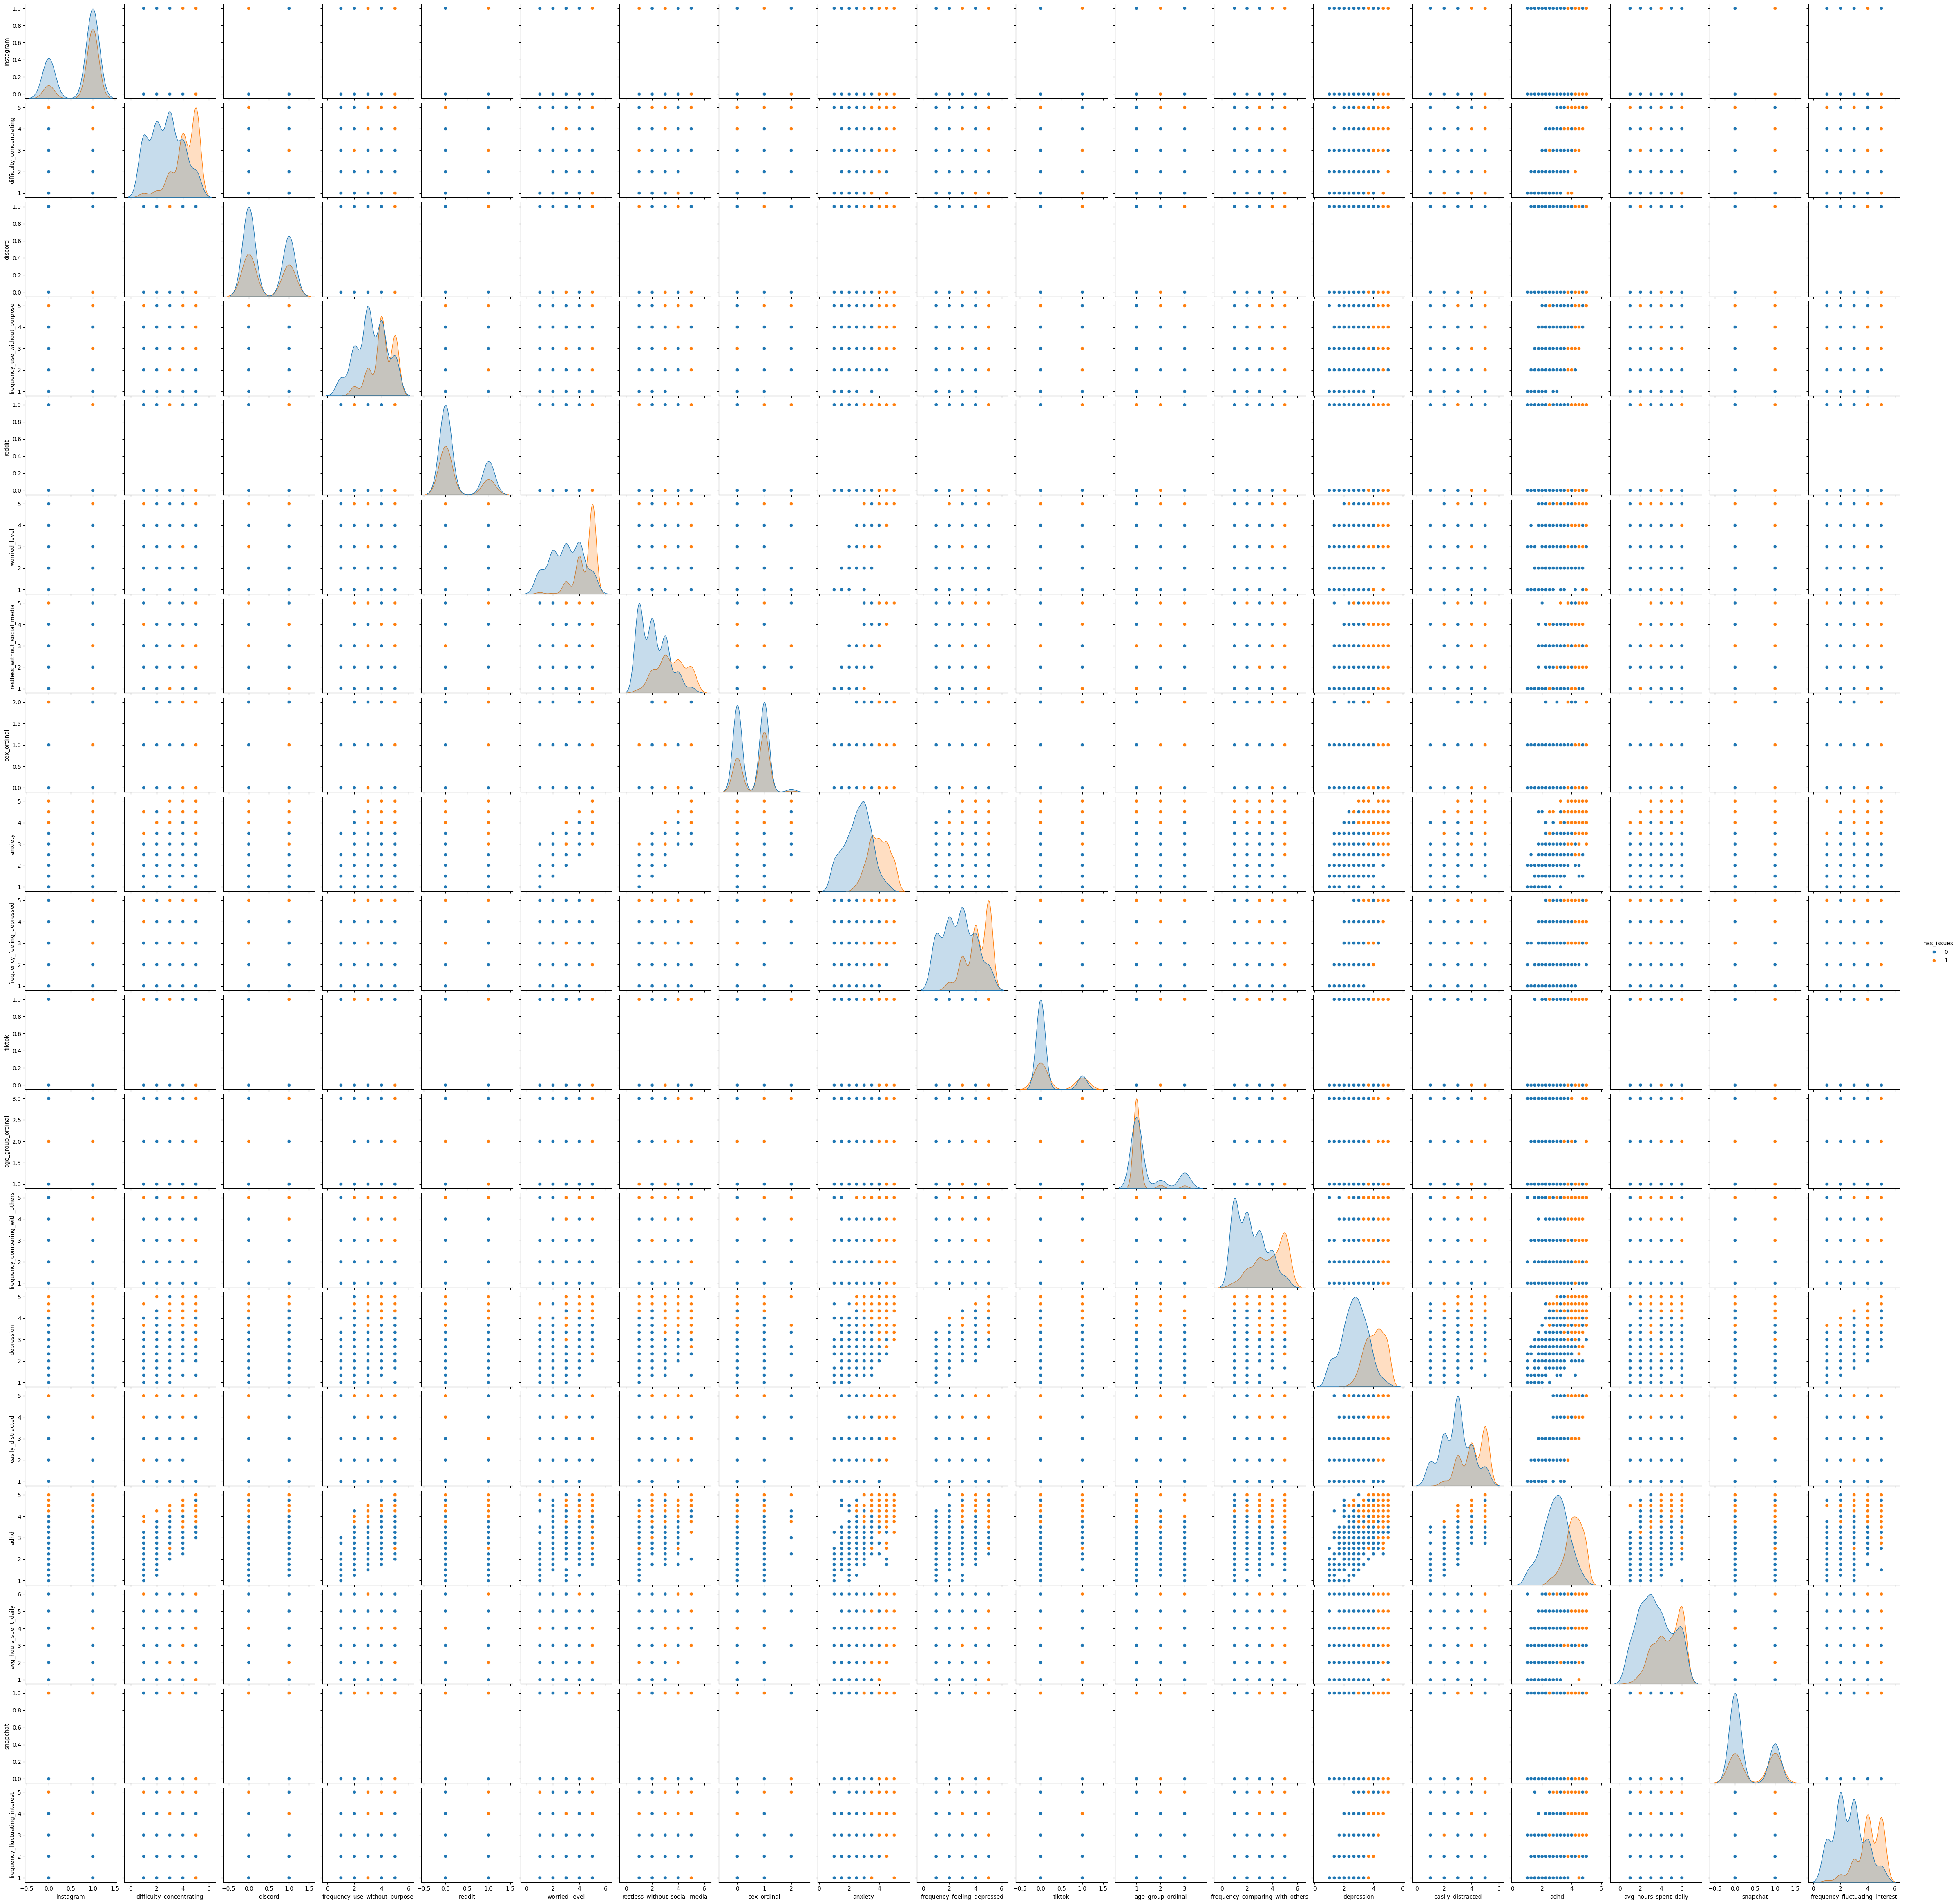

Statistically significant correlations:
Correlation result: avg_hours_spent_daily --> frequency_fluctuating_interest
Correlation result: avg_hours_spent_daily --> difficulty_concentrating
Correlation result: avg_hours_spent_daily --> worried_level
Correlation result: avg_hours_spent_daily --> frequency_feeling_depressed
Correlation result: avg_hours_spent_daily --> depression
Correlation result: avg_hours_spent_daily --> easily_distracted
Correlation result: avg_hours_spent_daily --> age_group_ordinal
Correlation result: avg_hours_spent_daily --> frequency_use_without_purpose
Correlation result: avg_hours_spent_daily --> restless_without_social_media
Correlation result: avg_hours_spent_daily --> anxiety
Correlation result: avg_hours_spent_daily --> adhd
Correlation result: discord --> age_group_ordinal
Correlation result: instagram --> age_group_ordinal


Not statistically significant correlations:
Correlation result:n avg_hours_spent_daily --> frequency_comparing_with_others
Correlati

In [10]:
def test_correlation_significance(correlation_matrix, column_pairs, alpha=0.05):
    n = len(correlation_matrix)
    results = []

    for pair in column_pairs:
        r = correlation_matrix.loc[pair[0], pair[1]]
        t = r * np.sqrt((n-2) / (1 - r**2))
        critical_t = stats.t.ppf(1.0 - alpha, n-2)

        if abs(t) > abs(critical_t):
            results.append((pair[0], pair[1], True))
        else:
            results.append((pair[0], pair[1], False))

    # Sort the results by whether the correlation is statistically significant
    results.sort(key=lambda x: x[2], reverse=True)

    # Print the results that are statistically significant
    print("Statistically significant correlations:")
    for column1, column2, significant in results:
        if significant:
            print(f"Correlation result: {column1} --> {column2}")

    print("\n")

    # Print the results that are not statistically significant
    print("Not statistically significant correlations:")
    for column1, column2, significant in results:
        if not significant:
            print(f"Correlation result:n {column1} --> {column2}")

    
# Flatten the list of tuples to get a list of column names
column_names_pairs = [item for pair in column_pairs for item in pair] + ['has_issues']
unique_column_names = list(set(column_names_pairs))

selected_columns = df[unique_column_names]
sns.pairplot(selected_columns, hue='has_issues', diag_kind='kde')
plt.show()
    

test_correlation_significance(correlation_matrix, column_pairs)

### t-test result:

A statistically significant relationship, as defined with an alpha level of 0.05, indicates a connection that is unlikely to have arisen by chance in the sample, providing a foundation for discussions regarding potential cause-and-effect relationships.

In the context of our analysis of the interplay between social media, demographics, and mental health, the identification of statistically significant correlations carries substantial weight. These relationships, particularly those related to daily hours spent on social networks and specific mental health symptoms, go beyond mere chance occurrences within the sample. Rigorous statistical scrutiny at the alpha level of 0.05 ensures that these observed relationships are not artefacts of random variation.

Numerous potential explanations for the observed relationships exist though, making it difficult to establish cause-and-effect relationships solely based on statistical significance.

In conclusion, the findings from this analysis, not only reveal significant associations but also provide robust evidence for the existence of meaningful relationships. These statistically significant correlations contribute valuable insights into the intricate dynamics of social media, demographics, and mental health.

In [11]:
def test_correlation_significance_only(correlation_matrix, column_pairs, alpha=0.05):
    n = len(correlation_matrix)
    results = []

    for pair in column_pairs:
        r = correlation_matrix.loc[pair[0], pair[1]]
        t = r * np.sqrt((n-2) / (1 - r**2))
        critical_t = stats.t.ppf(1.0 - alpha, n-2)

        if abs(t) > abs(critical_t):
            results.append(tuple(pair))

    return results

significant_corr_relationships = test_correlation_significance_only(correlation_matrix, column_pairs)
significant_corr_relationships

[('avg_hours_spent_daily', 'frequency_fluctuating_interest'),
 ('avg_hours_spent_daily', 'difficulty_concentrating'),
 ('avg_hours_spent_daily', 'worried_level'),
 ('avg_hours_spent_daily', 'frequency_feeling_depressed'),
 ('avg_hours_spent_daily', 'depression'),
 ('avg_hours_spent_daily', 'easily_distracted'),
 ('avg_hours_spent_daily', 'age_group_ordinal'),
 ('avg_hours_spent_daily', 'frequency_use_without_purpose'),
 ('avg_hours_spent_daily', 'restless_without_social_media'),
 ('avg_hours_spent_daily', 'anxiety'),
 ('avg_hours_spent_daily', 'adhd'),
 ('discord', 'age_group_ordinal'),
 ('instagram', 'age_group_ordinal')]

Visualizing only correlations that are statistically significant

/var/folders/7n/hn0s2v9n1j34zb6y9f0w6hbh0000gn/T/ipykernel_62801/2639755834.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  plt.scatter(


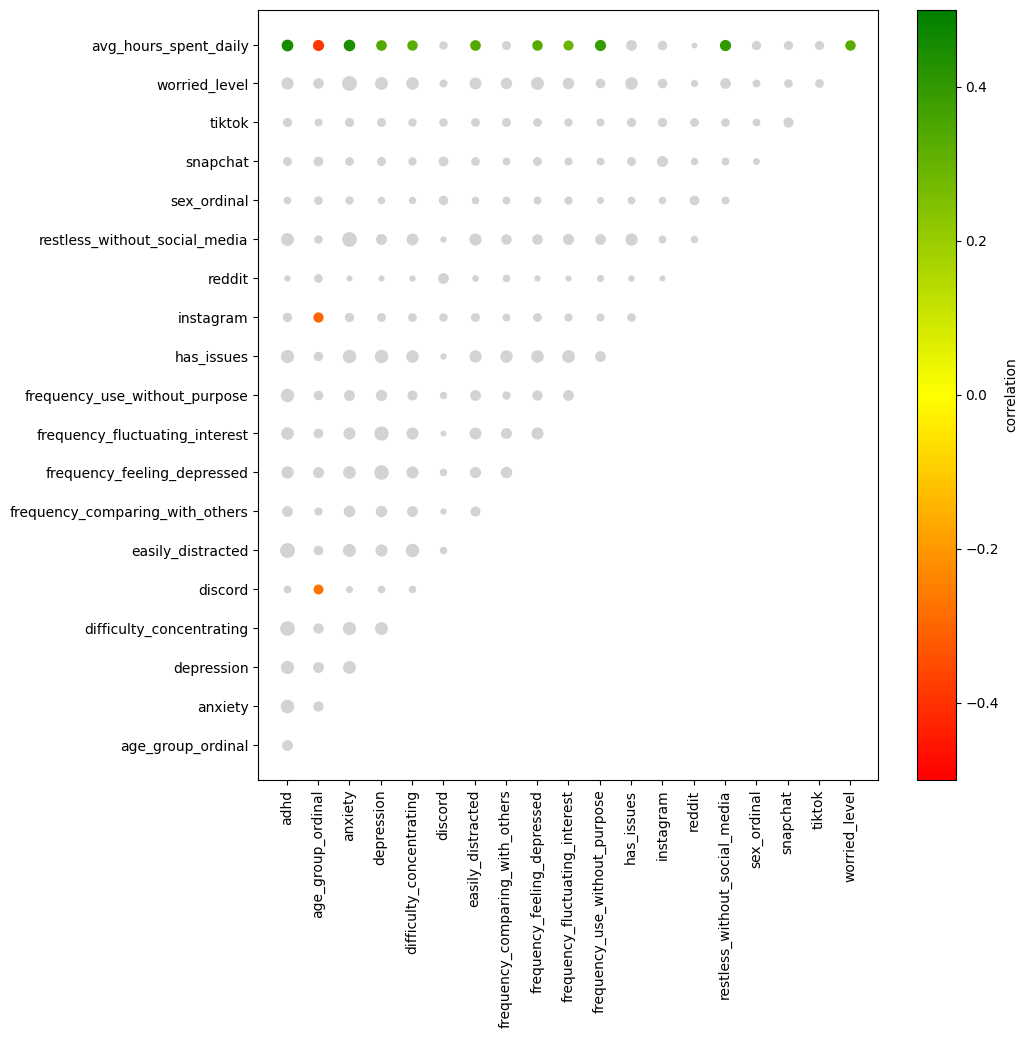

In [12]:
cmap = mcolors.LinearSegmentedColormap.from_list("RdYlGn9", ["red", "yellow", "green"])
norm = mcolors.Normalize(vmin=-0.5, vmax=0.5)
color_scalar_map=plt.cm.ScalarMappable(norm=norm, cmap=cmap)

rearranged_columns = [col for col in sorted(unique_column_names) if col != 'avg_hours_spent_daily'] + ['avg_hours_spent_daily']
pairs = list(combinations(rearranged_columns, 2))
inverted_pairs = [(col2, col1) for col1, col2 in pairs]

correlations = []
dot_sizes = []
for x, y in inverted_pairs:
    correlation = df[x].corr(df[y])
    correlations.append(correlation)
    dot_sizes.append((1 + 10 * abs(correlation)) * 10)

plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(pairs):
    is_significant = (x, y) in significant_corr_relationships or (y, x) in significant_corr_relationships
    plt.scatter(
        x, 
        y, 
        s=dot_sizes[i], 
        c=correlations[i] if is_significant else 'lightgray', 
        cmap=cmap if is_significant else None, 
        norm=norm
    )

plt.colorbar(mappable=color_scalar_map, label="correlation", ax=plt.gca())

plt.xticks(rotation=90)  # Rotate x-axis labels

plt.show()

The below pairplot takes time to be executed as it shows all variables

In [64]:
#sns.pairplot(df,hue='has_issues',diag_kind='kde')
    

In [65]:
# Useful if we want to plot only a subset of columns in the pair    
# selected_columns = df[['age', 'avg_hours_spent_daily', 'anxiety', 'depression', 'has_issues']]
# sns.pairplot(selected_columns, hue='has_issues', diag_kind='kde')
# plt.show()

## Logistic Regression

In [13]:
selected_columns = ['age_group_ordinal', 'avg_hours_spent_daily', 'discord', 'instagram']
X = numerical_df[selected_columns]
y = numerical_df["has_issues"]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model on the training set
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
classification_rep = metrics.classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.7731958762886598

Confusion Matrix:
[[58  8]
 [14 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        66
           1       0.68      0.55      0.61        31

    accuracy                           0.77        97
   macro avg       0.74      0.71      0.72        97
weighted avg       0.77      0.77      0.77        97



In [14]:
tn, fp, fn, tp = conf_matrix.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)


True Negatives: 58
False Positives: 8
False Negatives: 14
True Positives: 17


In [15]:
classification_report_values = metrics.classification_report(y_test, y_pred, output_dict=True)

class_metrics = {}

for key, value in classification_report_values.items():
    if key != 'accuracy':
        print(f"{key.capitalize()}:")
        class_metrics[key] = {}
        for metric, score in value.items():
            class_metrics[key][metric] = score
            print(f"{metric}: {score}")
        print()

0:
precision: 0.8055555555555556
recall: 0.8787878787878788
f1-score: 0.8405797101449276
support: 66.0

1:
precision: 0.68
recall: 0.5483870967741935
f1-score: 0.6071428571428571
support: 31.0

Macro avg:
precision: 0.7427777777777778
recall: 0.7135874877810362
f1-score: 0.7238612836438924
support: 97.0

Weighted avg:
precision: 0.7654295532646048
recall: 0.7731958762886598
f1-score: 0.7659761798040596
support: 97.0



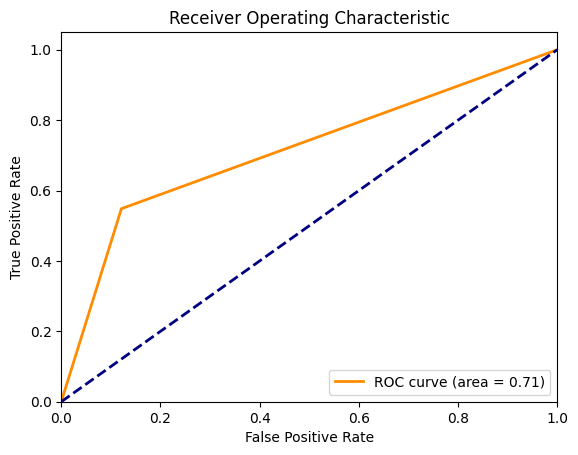

In [16]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Create a text for the logistic regression results

In [18]:
rounded_accuracy = round(accuracy*100, 2)
text_regression_result = f"""
Logistic Regression Result

Accuracy:
The model correctly predicted the class (either 0 or 1) about {rounded_accuracy}% of the time.

Confusion Matrix:
True Positives (TP): {tp} - The number of instances correctly predicted as class 1.
False Positives (FP): {fp} - The number of instances incorrectly predicted as class 1.
True Negatives (TN): {tn} - The number of instances correctly predicted as class 0.
False Negatives (FN): {fn} - The number of instances incorrectly predicted as class 0.
The confusion matrix shows the model's performance in terms of correctly and incorrectly predicted instances for each class.

Classification Report:

Precision:
Precision for class 0: Out of all instances predicted as class 0, {round(class_metrics['0']['precision'], 2)}% were actually class 0.
Precision for class 1: Out of all instances predicted as class 1, {round(class_metrics['1']['precision'], 2)}% were actually class 1.

Recall (Sensitivity):
Recall for class 0: Out of all actual class 0 instances, the model correctly predicted {round(class_metrics['0']['recall'], 2)}%.
Recall for class 1: Out of all actual class 1 instances, the model correctly predicted {round(class_metrics['1']['recall'], 2)}%.

F1-score is the harmonic mean of precision and recall, providing a balanced measure.
Weighted F1-score ({round(class_metrics['weighted avg']['f1-score'], 2)}): A balance between precision and recall for both classes, considering the class imbalance.

Support:
The number of actual occurrences of each class in the specified dataset.

Conclusion:
In conclusion, the logistic regression model exhibits an overall accuracy of {rounded_accuracy}%, 
demonstrating its ability to make correct predictions across both classes. The model's 
performance is characterized by a commendable precision for class 0, indicating reliable 
identification of instances belonging to this class. However, there is room for enhancement, 
particularly in improving recall for class 1. The trade-off between precision and recall, 
as reflected in the F1-score, suggests a need for fine-tuning to strike a better balance. 
Further optimization of hyperparameters and potentially exploring more advanced models may 
contribute to achieving a more robust and well-rounded predictive model. Understanding 
the specific requirements and implications of false positives and false negatives will be crucial 
in refining the model to align with the desired outcome.
"""

print(text_regression_result)


Logistic Regression Result

Accuracy:
The model correctly predicted the class (either 0 or 1) about 77.32% of the time.

Confusion Matrix:
True Positives (TP): 17 - The number of instances correctly predicted as class 1.
False Positives (FP): 8 - The number of instances incorrectly predicted as class 1.
True Negatives (TN): 58 - The number of instances correctly predicted as class 0.
False Negatives (FN): 14 - The number of instances incorrectly predicted as class 0.
The confusion matrix shows the model's performance in terms of correctly and incorrectly predicted instances for each class.

Classification Report:

Precision:
Precision for class 0: Out of all instances predicted as class 0, 0.81% were actually class 0.
Precision for class 1: Out of all instances predicted as class 1, 0.68% were actually class 1.

Recall (Sensitivity):
Recall for class 0: Out of all actual class 0 instances, the model correctly predicted 0.88%.
Recall for class 1: Out of all actual class 1 instances, th

In [19]:
print("Predicted Values using Logistic Regression: ", y_pred)
print()

print(f"Accuracy score using the Logistic regression model: {rounded_accuracy}%")


Predicted Values using Logistic Regression:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1
 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0]

Accuracy score using the Logistic regression model: 77.32%


# Conclusions

## Overview
Our investigation analysed the relationship between social media usage and mental health issues. It also took demographics into account and focused on factors such as ADHD, anxiety, and restlessness when not using socials. The vast majority of the sample consisted of young people, with a high representation of university students. Almost all participants reported using social networks. This investigation took into account most major social networks, such as Discord, Facebook, Instagram, Pinterest, Reddit, Snapchat, TikTok, Twitter and YouTube.

## Data analysis: correlation and associations
### Approach
We performed a correlation analysis across all numerical variables. Some categorical variables, such as social networks, have been converted to embeddings to take into account multiple selections. We also filtered out correlations belonging to the same group, that were redundant (e.g. ADHD with being easily distracted), or that were simply not relevant to answering our research questions (e.g. between mental health and demographics). This left us with a subset of high-interest correlations.

### Results
Discord and Reddit exhibited a weak negative correlation with sex, indicating higher male usage. TikTok, despite its youthful reputation, showed no clear correlation with age groups, while most other socials did. Snapchat correlated with depression, while TikTok and Instagram correlated with symptoms of ADHD and anxiety, which can be possibly explained by TikTok’s video feed and Instagram Reels mechanic providing high-rewarding fast-paced content. Notably, the time spent on social media demonstrated a moderate correlation with anxiety, ADHD, and restlessness.

### Statistical Significance and t-test Results
We performed a matrix t-test on each couple of numerical variables to establish the significance of their correlation. The results underscored the statistical significance of many of the observed correlations, supporting that such associations are unlikely to arise by chance. Among the relations identified in the correlation analysis, the link between using Discord or Instagram and belonging to the younger age group proved significant. However, previously observed relationships between Instagram, TikTok and Snapchat and mental health conditions were not found to be significant. Nevertheless, a link between time spent on social media and mental health issues proved significant. This seems to suggest that what matters the most is the time spent on social media rather than the specific kind of social media being used. It is paramount, however, to keep in mind that the complexity of potential explanations for such results emphasizes the need for cautious interpretation, nevertheless, the significance of these relationships, especially concerning the connection between daily hours on social networks and specific mental health symptoms, provides a strong foundation for discussions on potential cause-and-effect connections and opens to further research.

### Logistic Regression Model
The logistic regression model, employed for predictive analysis, achieved an accuracy of 77.32% and demonstrated a good level of precision for class 0. Despite these achievements, the model's performance, particularly in recall for class 1, suggests there is room for improvement. Possibly a larger dataset could improve these results. At the same time, other potential factors could be connected, and play a role in improving such kind of predictions. In addition, the F1 score highlighted the trade-off between precision and recall, indicating the need for further fine-tuning and potential exploration of advanced models.

### Conclusion and Implications
In conclusion, our study provides valuable insights into the dynamics of social media and mental health. While our analysis identified significant associations, it is crucial to recognize the limitations inherent in establishing any causal relationships. The varying correlations among different social media platforms emphasize the need for additional considerations in addressing mental health implications. Further research, optimization of models, and an understanding of the implications of false positives and false negatives are vital for refining predictive models aligned with desired outcomes.

# Limitations and Future Research Directions

## Limitations of the Study

### Sample composition
**Youth Bias** The predominant representation of individuals, aged 13-30, is particularly skewed towards teens and young adults and poses a limitation in generalizing our findings to a broader age demographic. **Overrepresentation of Students** The heavy concentration of university students may introduce some bias, limiting the application of our results to non-student populations. **Gender Imbalance** While the gender distribution aligns with the general population, the study may benefit from a more balanced representation to capture nuanced gender-related effects. **Individuals not using socials** The small percentage (0.6%) of people in the sample that reported not using social media at all, limits the ability to explore and understand the mental health characteristics of this subgroup. A more extensive representation of such individuals is necessary for a comprehensive analysis.

### Data Collection Methods
**Unknown Data Collection Method** The authors of the dataset did not provide information on how questionnaires have been submitted. Lack of clarity regarding the data collection method introduces uncertainty about the representativeness of the sample. Understanding whether the data collection occurred online, potentially introducing bias, or in specific locations frequented by young people is crucial.

### Final remark
Acknowledging and addressing these limitations in future research will contribute to a more comprehensive and nuanced understanding of the intricate interplay between social media, demographics, and mental health.

## Recommendations for Future Research
**Diverse and Representative Samples** Future studies should strive to gather a more diverse and representative sample, encompassing a broader age range and considering occupations beyond university students. This would enhance the generalizability of findings to the broader population. **Transparent Data Collection** Researchers should transparently report and detail the data collection methods to ensure the reliability and validity of the study. Providing information on methodology and on whether the data collection occurred online or in specific physical locations can aid in assessing potential biases. **Inclusion of Individuals Not Using Socials** Future research should intentionally include a more substantial representation of individuals who do not use social media. This would allow for a comprehensive understanding of mental health patterns among both users and non-users, contributing to a more tailored analysis. **Longitudinal Studies** Conducting longitudinal studies could offer insights into the dynamic relationship between social media use and mental health over time. This approach enables researchers to observe changes in mental health indicators and social media habits more accurately. **Platform-Specific Exploration** Investigating platform-specific interventions for mental health concerns can provide targeted strategies. Understanding how interventions tailored to certain platforms impact mental health outcomes can guide the development of more effective preventive measures. Additionally, investigating further possible correlations between specific social media platforms and their impact could be of particular interest in highlighting potential dangerous dynamics. **Qualitative Research** Complementing quantitative analyses with qualitative research methods can offer a richer understanding of individuals' experiences and perceptions regarding social media and mental health. Qualitative insights can provide context to quantitative findings and provide ideas for additional research. **Cross-Cultural Studies** Exploring cultural variations in the relationship between social media, demographics, and mental health can uncover nuanced patterns. Cross-cultural studies can highlight cultural influences on social media usage patterns and their mental health implications.